In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

file_path_env = '/fast/AG_Ohler/ekarimi/projects/FACS_Sampling/data'
OBS_FEATURES = ['celltype']

REFERENCES = [5, 10, 20, 25, 30]
METHODS = ['random', 'cubic', 'hopper', 'atomic']
SIZES = [50000, 100000, 200000, 300000]
REPS = [i for i in range(5)]
label_key = 'celltype'


directory = "mcc/benchmark"
PATH = os.path.join(file_path_env, directory)
os.makedirs(PATH, exist_ok=True)

In [2]:
def create_adata(df, obs_features=None):
    """
    Create an AnnData object from a DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    obs_features (list, optional): List of observation features. Defaults to ["Refined_clustering"].

    Returns:
    sc.AnnData: The created AnnData object.
    """
    # Set default observation features if none are provided
    obs_features = ["Refined_clustering"] if obs_features is None else obs_features

    # Create observation DataFrame
    obs = df[obs_features].astype('category')

    # Create variable DataFrame
    var = pd.DataFrame(index=df.drop(columns=obs_features).columns.values)

    # Extract data matrix
    X = df.drop(columns=obs_features).values

    # Create AnnData object
    adata = sc.AnnData(X, obs=obs, var=var)

    return adata


### Generate the directories

In [3]:
for reference in REFERENCES:
    for method in METHODS:
        for size in SIZES:
            for rep in REPS:
                path_rep = os.path.join(PATH, f"{reference}/{method}/{size}/{rep}")
                os.makedirs(path_rep, exist_ok=True)

### prepare data

In [4]:
address_adata_ref = os.path.join(file_path_env,'mcc', "adata.h5ad")
adata = sc.read_h5ad(address_adata_ref)


In [28]:
adata.uns['title']

'Major cell cluster: Mesoderm'

In [ ]:
['author_cell_type', 'cell_type', ]

In [9]:
adata

AnnData object with n_obs × n_vars = 3267338 × 45854
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'author_experimental_id', 'author_day', 'author_somite_count', 'author_major_cell_cluster', 'author_cell_type', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_short_name', 'chr', 'start', 'end', 'strand', 'gene_type', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'author_day_colors', 'author_somite_count_colors', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_umap'
    layers: 'raw.X'

In [29]:
import scanpy as sc
import scipy.sparse as sp


# 1. Keep only ['author_cell_type', 'cell_type'] in obs
adata.obs = adata.obs[['author_cell_type', 'cell_type']]

# 2. Assign raw.X to X
if adata.raw is not None:
    adata.X = adata.raw.X.copy()
    # Remove raw.X from the AnnData object
    adata.raw = None
else:
    raise ValueError("The 'raw' layer is missing from the AnnData object.")

# 3. Compress X using CSR format (if it's not already sparse)
if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)




In [30]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [31]:
adata.X.min(), adata.X.max() 

(np.float32(0.0), np.float32(4168.0))

In [33]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [34]:
sc.pp.log1p(adata)

In [35]:
adata.X.min(), adata.X.max() 

(np.float32(0.0), np.float32(8.295673))

In [36]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()


In [37]:
adata.var = adata.var[['gene_short_name']]  # Keep only gene_short_name in var
adata.uns.clear()  # Remove unnecessary unstructured data
adata.obsm.clear()  # Remove all multi-dimensional data

In [45]:
adata

AnnData object with n_obs × n_vars = 3267236 × 3065
    obs: 'author_cell_type', 'cell_type', 'n_genes'
    var: 'gene_short_name'
    layers: 'raw.X'

In [ ]:
# # 4. Find highly variable genes and subset to keep 2000 genes
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# # Subset the adata object to keep only highly variable genes
# adata = adata[:, adata.var.highly_variable].copy()

# # 5. Remove unnecessary information (var and other unwanted layers)
# adata.var = adata.var[['gene_short_name']]  # Keep only gene_short_name in var
# adata.uns.clear()  # Remove unnecessary unstructured data
# adata.obsm.clear()  # Remove all multi-dimensional data

# # Save the new AnnData object (optional)
# adata.write_h5ad('filtered_adata.h5ad')

In [66]:
adata.obs.rename(columns={'cell_type': 'celltype'}, inplace=True)

In [53]:
adata.obs.to_csv('cell_type_mapping.csv', header=True)

In [58]:
# df = pd.read_csv('cell_type_mapping.csv', index_col=0)
# df.head()

In [67]:
adata

AnnData object with n_obs × n_vars = 3267236 × 3065
    obs: 'author_cell_type', 'celltype', 'n_genes'
    var: 'gene_short_name'
    layers: 'raw.X'

In [68]:
label_key = 'celltype'

adata.obs['celltype'] = adata.obs['celltype'].astype('category')
adata.obs['author_cell_type'] = adata.obs['author_cell_type'].astype('category')
adata.var.index = adata.var.index.astype('object')

address_adata = os.path.join(file_path_env,'mcc', "adata_clean.h5ad")
adata.write_h5ad(address_adata)

In [69]:
adata

AnnData object with n_obs × n_vars = 3267236 × 3065
    obs: 'author_cell_type', 'celltype', 'n_genes'
    var: 'gene_short_name'
    layers: 'raw.X'

### Generate the references

In [4]:
# adata_clean is the backup of the proccessed adata.
address_adata_ref = os.path.join(file_path_env,'mcc', "adata_clean.h5ad")
adata = sc.read_h5ad(address_adata_ref)

In [5]:
adata.obs['author_cell_type'].value_counts()

author_cell_type
Lateral plate and intermediate mesoderm    745494
Fibroblasts                                648047
Sclerotome                                 476671
Facial mesenchyme                          382746
Limb mesenchyme progenitors                223422
Dermatome                                  198888
Early chondrocytes                         144281
Pre-osteoblasts (Sp7+)                     135839
Dermomyotome                               131048
Chondrocytes (Atp1a2+)                     118412
Mesodermal progenitors (Tbx6+)              50325
Chondrocytes (Otor+)                        12063
Name: count, dtype: int64

In [6]:
adata.obs['celltype'].value_counts()

celltype
mesodermal cell            1463100
lateral mesodermal cell     745494
fibroblast                  648047
chondrocyte                 274756
osteoblast                  135839
Name: count, dtype: int64

In [7]:
import numpy as np
np.random.seed(12)

# Identify the index of cells that are Pre-osteoblasts (Sp7+)
osteoblasts_idx = adata.obs[adata.obs['celltype'] == 'osteoblast'].index

# Randomly sample fewer than 30,000 cells from the osteoblasts group
sampled_idx = np.random.choice(osteoblasts_idx, size=30000, replace=False)

# Keep the rest of the cells that are not Pre-osteoblasts (Sp7+)
remaining_idx = adata.obs[adata.obs['celltype'] != 'osteoblast'].index

# Combine the sampled Pre-osteoblasts (Sp7+) with the remaining cells
final_idx = np.concatenate([sampled_idx, remaining_idx])

# Subset the adata with the final indices
adata_sampled = adata[final_idx].copy()


In [8]:
adata_sampled.obs['celltype'].value_counts()

celltype
mesodermal cell            1463100
lateral mesodermal cell     745494
fibroblast                  648047
chondrocyte                 274756
osteoblast                   30000
Name: count, dtype: int64

In [9]:
adata_sampled.shape

(3161397, 3065)

In [10]:
for ref in REFERENCES:
    np.random.seed(164 + ref)
    output_address = os.path.join(PATH, f"{ref}/adata.h5ad")
    
    if ref ==30:
        adata_sampled.write(output_address)
    else:
        random_indices = np.random.choice(adata_sampled.shape[0], size=int(ref*100000), replace=False)
        sampled_adata = adata_sampled[random_indices].copy()
        sampled_adata.write(output_address)
    print(ref)

5
10
20
25
30


### Test

In [2]:
import pickle
res = {}
new_label_orders = {}
REFERENCES = [5, 10, ]
label_key = 'celltype'
SIZES = [50000, 100000, 200000, 300000]
REPS = [0, 1, 2, 3, 4]

for ref in REFERENCES:
    address_adata = os.path.join(file_path_env,'mcc', f"benchmark/{ref}/adata.h5ad")
    adata = sc.read_h5ad(address_adata)

    real_counts = adata.obs[label_key].value_counts()
    rare_dict = real_counts < adata.shape[0]/100
    rare_types = [x for x in rare_dict.keys() if rare_dict[x]==True]
    adata.obs['rare'] = adata.obs.apply(lambda x: True if x[label_key] in rare_types else False , axis=1)
    adata.obs['real_count'] = adata.obs.apply(lambda x: real_counts[x[label_key]] , axis=1)

    label_order = adata.obs[label_key].value_counts().keys().values
    
    group_dict = {
        label_key:[],
        'count':[],
        'method':[],
        'ref_size':[],
        'sample_size':[],
        'rep':[],
        # 'rare':[],
        'real_count':[],
                 }

    for size in SIZES:
        for method in METHODS:
            for rep in REPS:
                if method == 'atomic':
                    if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")):
                        atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")
                        indices = pd.read_csv(atomic_address)['x'].values.astype(str)
                    else:
                        continue
                else:
                    samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                    with open(samples_address, 'rb') as handle:
                         samples= pickle.load(handle)
                    indices = samples[0]

                counts = adata[indices].obs[label_key].value_counts().tolist()
                labels = adata[indices].obs[label_key].value_counts().keys().tolist()
                method_rep = [method for _ in counts]
                size_rep = [size for _ in counts]
                ref_rep = [ref for _ in counts]
                rep_rep = [rep for _ in counts]
                real_count = real_counts[labels].values
                # rare = rare_dict[labels].values

                group_dict[label_key].extend(labels)
                group_dict['count'].extend(counts)
                group_dict['method'].extend(method_rep)
                group_dict['ref_size'].extend(ref_rep)
                group_dict['sample_size'].extend(size_rep)
                group_dict['rep'].extend(rep_rep)
                # group_dict['rare'].extend(rare)
                group_dict['real_count'].extend(real_count)
                
                
                

    gdf = pd.DataFrame.from_dict(group_dict)
    # cc = adata.obs[label_key].value_counts()
    # gdf['coverage_percent'] = gdf.apply(lambda x: (x['count'] / cc[x[label_key]]) * 100, axis=1)
    
    res[ref] = gdf[gdf[label_key].isin(rare_types)]
    
    new_label_order = []
    for i in range(len(label_order)):
        if label_order[i] in rare_types:
            new_label_order.append(label_order[i])
    new_label_orders[ref] = new_label_order

In [3]:
output2 = {}
for size in SIZES:    
    output2[size] = None
    b= []
    for ref in REFERENCES:
        df = res[ref]
        a = []
        for method in METHODS:
            sample_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['count'].sum()
            sample_count /= len(REPS)
            # real_count = df[(df['ref_size'] == ref) & (df['method'] == method) & (df['sample_size'] == size)]['real_count'].sum()
            # real_count /= len(REPS)
            # a.append(sample_count/real_count)
            a.append(sample_count)
        b.append(a)
    b = np.array(b).T
    output2[size] = b

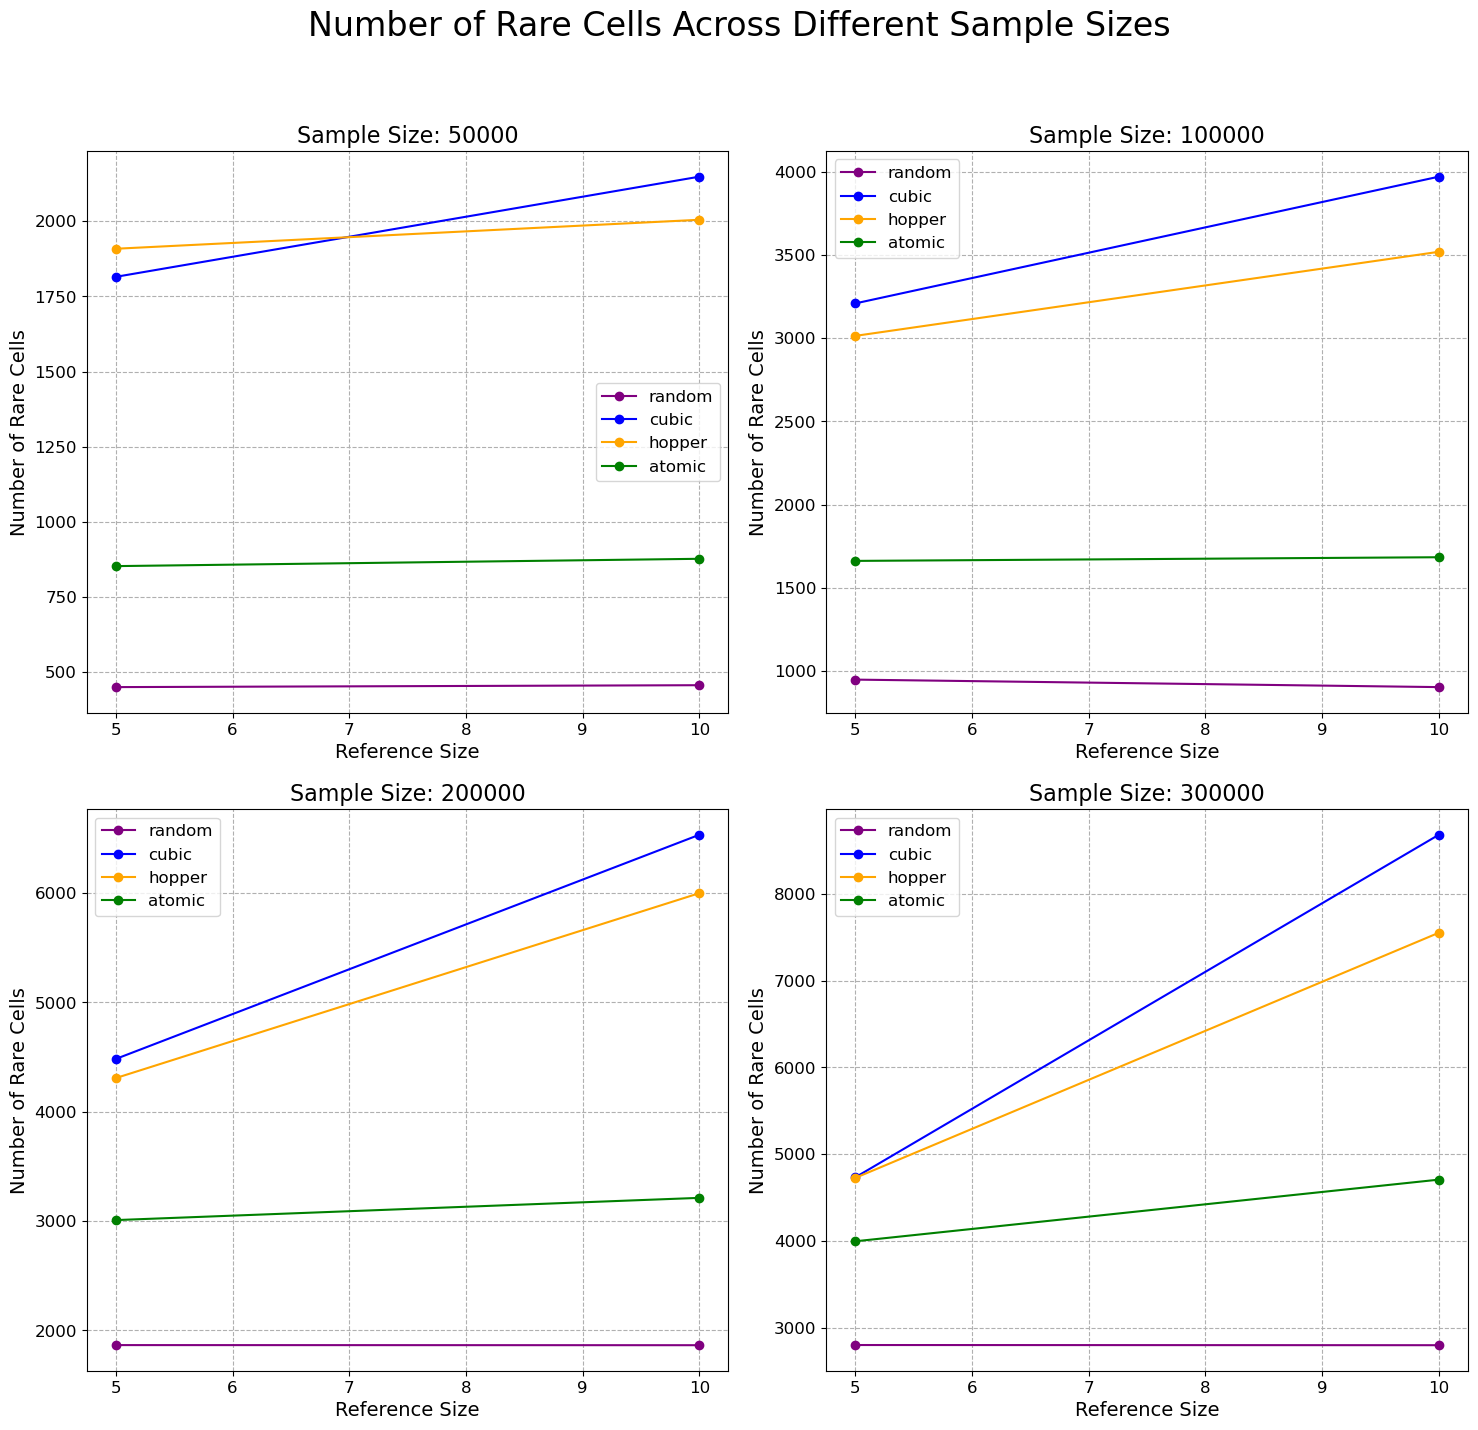

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'axes.titlesize': 16, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Assuming 'a' is your dataset container with 7 datasets, and 'methods_list' is defined
# a = {...}
# methods_list = [...]

# Fixed X-axis values
x_values = np.array(REFERENCES)

# Define the number of rows and columns for the subplot grid, accommodating 7 plots
n_rows = 3  # Adjust the number of rows to fit 7 plots
n_cols = 2

# Colors for each method
colors = ['purple', 'blue', 'orange', 'green']

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))  # Adjust figsize as needed

y_min = 0  # Replace with your desired minimum y value
y_max = 0.9  # Replace with your desired maximum y value

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over your dataset container 'a' which has the datasets for each 'batch_id'
for i, size in enumerate(output2.keys()):
    y_streams = output2[size]
    ax = axes[i]  # Select the subplot
    
    # Plotting each stream for the current subplot
    for j, y_stream in enumerate(y_streams):
        ax.plot(x_values, y_stream, '-o', color=colors[j % len(colors)], label=METHODS[j])

    # Customizations for the subplot
    ax.set_xlabel('Reference Size')
    ax.set_ylabel('Number of Rare Cells')
    ax.set_title(f'Sample Size: {size}')
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls="--")
    ax.legend()

# Hide any unused subplots if the number of subplots exceeds the datasets
for i in range(len(output2), n_rows * n_cols):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlapping
fig.suptitle('Number of Rare Cells Across Different Sample Sizes', size=24, y=1.02)

fig.tight_layout()

# plt.subplots_adjust(top=0.9)

# Save the entire figure with all subplots to a file
plt.savefig('rare_population_coverage_sample_size_fixed.png', format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()
